In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import tables, math, os, sys, scipy
import healpy as hp
import matplotlib.pylab as plt
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
sys.path.append('../')
from core.tools import *
from scipy.interpolate import splrep, splev

from core.tools import _trans

In [4]:
from core.analysis_tools.public_pdfs import *
from core.analysis_tools.amtospheric_background import *
from core.analysis_tools.analysis import ReducedSpatialTemplatePowerLawAnalysis
from core.analysis_tools.signal_pdfs import SinglePowerLaw
from core.analysis_tools.basic_spatial_templates import Galaxy

In [5]:
effective_areas = EffectiveAreas()
energy_smearing = TrueEnergy2ReconstructedEnergySmearing(
    mc_path='/Users/mhuber/Downloads/mc_pass2_IC79_IC86_baseline_V06.npy')

In [6]:
phi100s = 10**np.linspace(-23,-16, 20)
gammas = np.arange(1.5,4.1,0.25)
signal_model = SinglePowerLaw(phi0_bins=phi100s, gamma_bins=gammas)

In [7]:
gp_template = Galaxy(size_gplane=5, radius_gcenter=15.)

In [8]:
atm_bckg = AtmosphericBackground(theta_angles=[0])

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): GlobalSplineFitBeta /Users/mhuber/AtmosphericShowers/Data/GSF_spline_20171007.pkl.bz2


In [9]:
sindec_bins = np.linspace(-1,1,40)
ra_bins = np.linspace(0, np.pi*2, num=41)
log_ereco_bins = np.arange(2,7.1,0.2)

In [10]:
gp_ana = ReducedSpatialTemplatePowerLawAnalysis(sindec_bins, ra_bins, log_ereco_bins,
                          energy_smearing=energy_smearing, 
                          atm_bckg=atm_bckg, effective_areas=effective_areas,
                          livetime=6., signal_model=signal_model, 
                          spatial_template=gp_template)

(25, 154)
(25, 154)


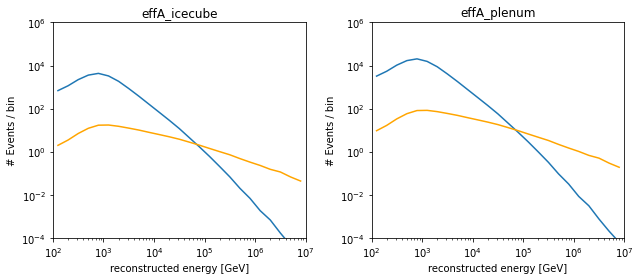

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(9,4))

d_bckg = gp_ana._generate_background_expectation('numu_conv', astro_bckg=False)
#d_astro = gp_ana._generate_background_expectation(atm_keys=[], astro_bckg=True)
params = [1.44e-18, 2.28]
d_sig = gp_ana._generate_signal_expectation(params)
for k,exp_key in enumerate(d_bckg.keys()):

    
    ax =axes[k]
    ax.set_title(exp_key)
    
    db = d_bckg[exp_key]
    #da = d_astro[exp_key]
    ds = d_sig[exp_key][0]
    
    print(ds.shape)
    ax.plot(gp_ana.ereco_mids, np.sum(db,axis=1))
    #ax.plot(kra_ana.ereco_mids, np.sum(da,axis=(1,2)), color='red')
    ax.plot(gp_ana.ereco_mids, np.sum(ds,axis=1), color='orange')
    
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim(1e2,1e7)
    ax.set_ylim(1e-4,1.e6)
    
    ax.set_xlabel('reconstructed energy [GeV]')
    ax.set_ylabel('# Events / bin')


    
fig.tight_layout()



# Do some background trials 

In [12]:
bckg_trials = gp_ana.do_trials(n_trials=50, 
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False))

(1, 25, 154, 50) (50, 750) (50, 25, 30)
(1, 25, 154, 50) (50, 750) (50, 25, 30)


In [13]:
sys.path.append('/Users/mhuber/skylab/SVN_stable_v2-03/')
from _svnskylab.utils import FitDeltaChi2, delta_chi2

0.28
0.3


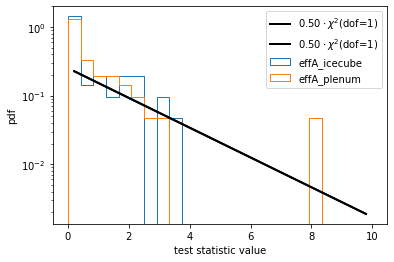

In [14]:
fig, ax = plt.subplots()

ts_bins = np.linspace(0,10,25)
for exp_key, trials in bckg_trials.items():
    ax.hist(trials['ts'], bins=ts_bins, histtype='step', label=exp_key, 
            density=True)
    
    eta = np.sum(trials['ts']==0) / float(len(trials))
    print(eta)
    xvals = get_mids(ts_bins)
    fit_func = delta_chi2(eta=0.5, df=2.)
    fit_vals = fit_func.pdf(xvals)
    fit_vals[:] /= (np.sum(fit_vals) /(fit_func.eta))
    ax.plot(xvals, fit_vals / np.diff(xvals)[0] , color='black', lw=2., 
                label=r'$0.50\cdot \chi^2$(dof=1)')
    
ax.set_xlabel('test statistic value')
ax.set_ylabel('pdf')

ax.legend()
ax.set_yscale('log')



# Do some trials with injected signal to check if it can be recovered


In [15]:
phi0_exp, gamma_exp = 1.44e-18, 2.28
inj_trials = gp_ana.do_trials(n_trials=250, signal_kwargs={'params':[phi0_exp, gamma_exp]},
                               bckg_kwargs =dict(atm_keys=['numu_conv'], astro_bckg=False),
                              )

(1, 25, 154, 250) (250, 750) (250, 25, 30)
(1, 25, 154, 250) (250, 750) (250, 25, 30)


effA_icecube 29.350870886307465
effA_plenum 105.07813003781698


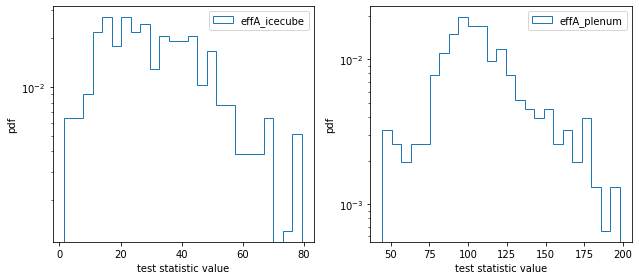

In [16]:
fig, axes = plt.subplots(ncols=2,figsize=(9,4))


for k, (exp_key, trials) in enumerate(inj_trials.items()):
    ax = axes[k]
    h,ts_bins, _= ax.hist(trials['ts'],bins=25, histtype='step', label=exp_key, 
            density=True)
    
    print(exp_key, np.median(trials['ts']))
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('test statistic value')
    ax.set_ylabel('pdf')
    
fig.tight_layout()

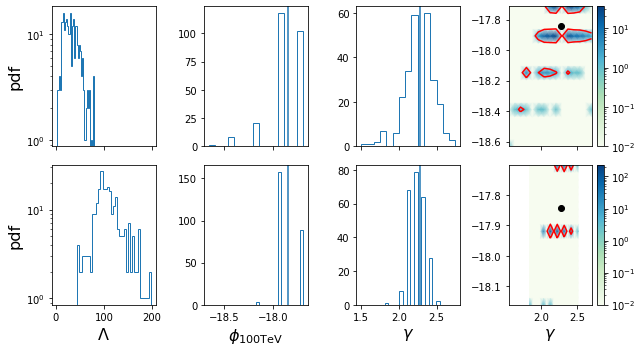

In [17]:
fs=16
fig, axes = plt.subplots(ncols=4,nrows=2,  figsize=(9,5.), sharex='col')

for k, (exp_key,trials) in enumerate(inj_trials.items()):
    
    ################# ts values #######################
    ax = axes[k, 0]
    bins = np.linspace(0,25, 35)
    ax.hist(trials['ts'], bins=35, histtype='step')
    ax.set_yscale('log')
    if k==1:
        ax.set_xlabel(r'$\Lambda$', fontsize=fs)
    ax.set_ylabel(r'pdf', fontsize=fs)
    
    
    ################# phi0 values #######################
    ax = axes[k, 1]
    ax.hist(np.log10(trials['phi0']), bins=15, histtype='step')
    
    ax.axvline(np.log10(phi0_exp))
    if k==1:
        ax.set_xlabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    
    ################# gamma values #######################
    ax = axes[k, 2]
    ax.hist(trials['gamma'], bins=15, histtype='step')
    ax.axvline(gamma_exp)
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    
    
    ################# 2d phi0-gamma values #######################
    ax = axes[k, 3]
    
    p = np.histogram2d(trials['gamma'], np.log10(trials['phi0']),
              bins=(15, 20),  normed=True)
    
    
    p[0][p[0]<1e-3] = 1e-3
    p0=ax.pcolormesh(get_mids(p[1]), get_mids(p[2]), p[0].T, 
                  cmap='GnBu', norm=LogNorm(), vmin=1e-2, shading='gouraud')
    
    fig.colorbar(p0, ax=ax)
    
    if k==1:
        ax.set_xlabel(r'$\gamma$', fontsize=fs)
    #ax.set_ylabel(r'$\phi_{100\mathrm{TeV}}$', fontsize=fs)
    #fig.colorbar(p[3], ax=ax)
    
    
    # add the contours etc
    
    unc_mat = p[0].flatten()
    X = np.empty((len(unc_mat), ), dtype=[('idx',int), ('p',float)])
    X['idx'] = np.arange(len(unc_mat))
    X['p'] = unc_mat / np.sum(unc_mat) 

    X = np.sort(X,order='p')
    X['p'] = np.cumsum(X['p'])
    X = np.sort(X, order='idx')

    Unc_mat = np.copy(X['p'])

    
    ax.contour(get_mids(p[1]), get_mids(p[2]), Unc_mat.reshape(p[0].shape).T * 100., levels=[5. ], 
                   linestyles = [ 'solid'], colors=['red'])
    

    ax.scatter([gamma_exp], [np.log10(phi0_exp)], marker='o', color='black',
              zorder=10)
    
fig.tight_layout()